In [1]:
import sys
sys.path.append('../code/') 
import mocap_functions
from functools import partial
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
from hnn_core.utils import smooth_waveform
from scipy.signal import savgol_filter
#sns.set()
#sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0")
device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

2023-02-27 21:39:22.352578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 21:39:22.685705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 21:39:22.685744: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 21:39:22.724848: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-27 21:39:23.743047: W tensorflow/stream_executor/platform/de

In [2]:
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/', kinematic_suffix='_cam4')


num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [3]:
null_percent = kinematic_df.groupby('name')['posData'].apply(list).map(
    np.concatenate).map(lambda x: np.sum(np.isnan(x)) / len(x))



In [4]:
smooth_func = partial(savgol_filter, window_length=21, polyorder=3)
#kinematic_df['posData'] = kinematic_df['posData'].map(smooth_func)
neural_df['rates'] = neural_df['rates'].map(smooth_func)

marker_list = ['ulnar_distal', 'carpal', 'thumbProx', 'ringProx', 'middleProx', 'pinkyProx', 'indexProx']

mask_list = [kinematic_df['name'].str.contains(pat=pat) for pat in marker_list]

wrist_df = kinematic_df[np.logical_or.reduce(mask_list)]



/tmp/ipykernel_7470/865322538.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df[mask]['layout']


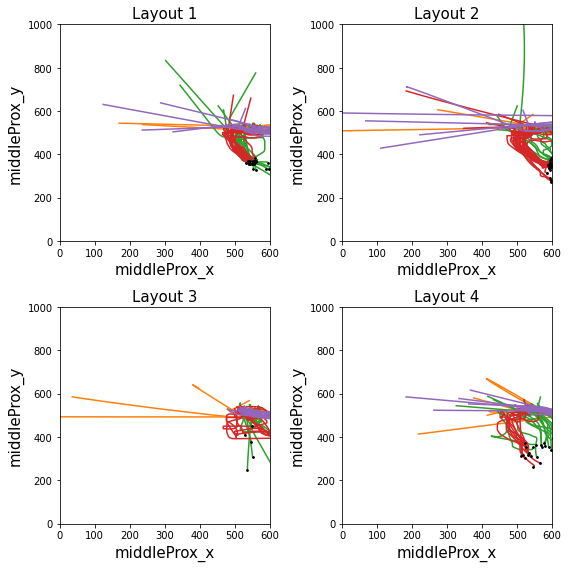

In [5]:
marker_name = 'middleProx'

plt.figure(figsize=(8,8))
fontsize=15

avg_pos_dict = dict() # Store average marker position based on layout/position at trajectory end
for position_idx in range(1,5):
    for layout_idx in range(1,5):
        plt.subplot(2,2,layout_idx)
        mask = np.logical_and(kinematic_df['position'] == position_idx, kinematic_df['layout'] == layout_idx)
        filtered_df = kinematic_df[mask]

        x_data =  filtered_df[filtered_df['name'] == f'{marker_name}_x']['posData'].values
        y_data =  filtered_df[filtered_df['name'] == f'{marker_name}_y']['posData'].values

        handpos_x = list()
        handpos_y = list()
        for plot_data in zip(x_data, y_data):
            plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
            plt.plot(plot_data[0], plot_data[1], color=f'C{position_idx}')

            handpos_x.append(plot_data[0][-1])
            handpos_y.append(plot_data[0][-1])

        avg_pos_dict[(position_idx, layout_idx)] = dict()
        avg_pos_dict[(position_idx, layout_idx)]['x'] = np.mean(handpos_x)
        avg_pos_dict[(position_idx, layout_idx)]['y'] = np.mean(handpos_y)


        filtered_df[mask]['layout']

        plt.xlim(0, 600)
        plt.ylim(0, 1000)

        plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
        plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
        plt.title(f'Layout {layout_idx}', fontsize=fontsize)

plt.tight_layout()
        

/tmp/ipykernel_7470/2043014715.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df[mask]['layout']


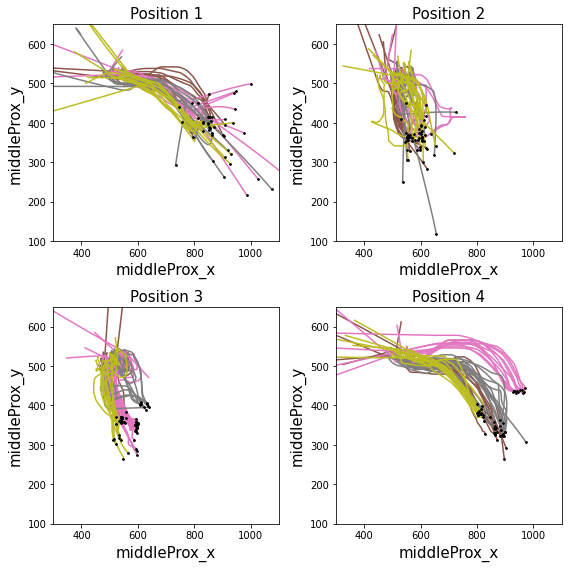

In [6]:

plt.figure(figsize=(8,8))
fontsize=15

for position_idx in range(1,5):
    for layout_idx in range(1,5):
        plt.subplot(2,2,position_idx)
        mask = np.logical_and(kinematic_df['position'] == position_idx, kinematic_df['layout'] == layout_idx)
        filtered_df = kinematic_df[mask]

        x_data =  filtered_df[filtered_df['name'] == f'{marker_name}_x']['posData'].values
        y_data =  filtered_df[filtered_df['name'] == f'{marker_name}_y']['posData'].values

        for plot_data in zip(x_data, y_data):
            plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
            plt.plot(plot_data[0], plot_data[1], color=f'C{layout_idx+4}')

        filtered_df[mask]['layout']

        plt.xlim(300, 1100)
        plt.ylim(100, 650)

        plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
        plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
        plt.title(f'Position {position_idx}', fontsize=fontsize)

plt.tight_layout()
        

In [7]:
# Code to add avergage hand pos

# df_list = list()
# for trial_idx in neural_df['trial'].unique():
#     filtered_df = neural_df[neural_df['trial'] == trial_idx]
#     trial_layout = filtered_df['layout'].values[0]
#     trial_position = filtered_df['position'].values[0]

#     trial_len = filtered_df['rates'].values[0].shape[0]
    
#     handpos_x = np.repeat(avg_pos_dict[(trial_position, trial_layout)]['x'], trial_len)
#     handpos_y = np.repeat(avg_pos_dict[(trial_position, trial_layout)]['y'], trial_len)


#     row = pd.DataFrame({'rates': [handpos_x, handpos_y], 'rates_video': [None, None],
#                           'unit': ['handpos_x', 'handpos_y'], 'trial': [trial_idx, trial_idx],
#                           'layout': [trial_layout, trial_layout],
#                           'position': [position_idx, position_idx], 'count': [None, None]})
    
#     # row_y = pd.DataFrame({'rates': hand_pos_y, 'rates_video': None, 'unit': 'hand_pos_y',
#     #          'trial': trial_idx, 'layout': trial_layout, 'position': position_idx, 
#     #          'count': None})
    
#     filtered_df = pd.concat([filtered_df, row])

#     df_list.append(filtered_df)

# neural_df = pd.concat(df_list)

In [8]:
num_neurons = 12
rng = np.random.default_rng(222)
random_units = rng.choice(range(85), size=85).astype(str)

unit_mask = np.in1d(neural_df['unit'].values, random_units[:num_neurons])
layout_mask = neural_df['unit'].str.contains(pat='layout')
position_mask = neural_df['unit'].str.contains(pat='position')
handpos_mask = neural_df['unit'].str.contains(pat='handpos')

# neural_df = neural_df[np.logical_or.reduce([unit_mask, layout_mask, position_mask])].reset_index(drop=True)
neural_df = neural_df[np.logical_or.reduce([unit_mask, layout_mask])].reset_index(drop=True)
# neural_df = neural_df[np.logical_or.reduce([unit_mask, position_mask])].reset_index(drop=True)
# neural_df = neural_df[np.logical_or.reduce([unit_mask, handpos_mask])].reset_index(drop=True)

In [9]:
# Filter dataframes add or remove layout info
nolayout_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='layout'))
noposition_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='position'))

eye_kinematic_mask = kinematic_df['name'].str.contains(pat='eye')
corneal_kinematic_mask = kinematic_df['name'].str.contains(pat='corneal')

temp_eye_df = kinematic_df[np.logical_or(eye_kinematic_mask, corneal_kinematic_mask)]
kinematic_df = kinematic_df[np.logical_and.reduce([nolayout_kinematic_mask, noposition_kinematic_mask, ~eye_kinematic_mask, ~corneal_kinematic_mask])]

nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
nohandpos_neural_mask = ~(neural_df['unit'].str.contains(pat='handpos'))
notask_neural_df = neural_df[np.logical_and.reduce([nolayout_neural_mask, noposition_neural_mask, nohandpos_neural_mask])]





In [10]:
#eye_data = [[data] for data in temp_eye_df['posData'].tolist()]
eye_dict = {'rates': temp_eye_df['posData'].tolist(), 'unit': temp_eye_df['name'].tolist(), 'trial': temp_eye_df['trial'].tolist(),
            'layout': temp_eye_df['layout'].tolist(), 'count': np.repeat(0.0, len(temp_eye_df))}

eye_df = pd.DataFrame(eye_dict).reset_index()

task_neural_noeyes_df = neural_df.copy()
notask_neural_noeyes_df = notask_neural_df.copy()
task_neural_eyes_df_ = pd.concat([eye_df, neural_df])
notask_neural_eyes_df = pd.concat([eye_df, notask_neural_df])
            

In [11]:
#GRU architecture for decoding kinematics
class model_gru(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dropout, device, bidirectional=False,
                 cat_features=None):
        super(model_gru, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.hidden_dim = hidden_dim       
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.cat_features = cat_features

        #Defining the layers
        self.gru = nn.GRU(input_size, self.hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)   

        # Fully connected layer
        if cat_features is not None:
            self.fc = nn.Linear((self.hidden_dim + np.sum(self.cat_features))*num_directions, output_size)
        else:
            self.fc = nn.Linear(self.hidden_dim*num_directions, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.gru(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous()
        if self.cat_features is not None:
            out = torch.cat([out, x[:, :, self.cat_features]], 2)
        #print(out.size())
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        #GRU initialization
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)

        return hidden

### Use function to create train/test sets with each data frame

In [12]:
def run_wiener(pred_df, neural_df, neural_offset, task_info=True, window_size=10):
  if task_info:
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-4:] = np.ones(4)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None
    
  data_arrays, generators = mocap_functions.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, 
    exclude_neural=exclude_processing, window_size=window_size, flip_outputs=True)

  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Fit and run wiener filter
  model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
  model_wr.fit(X_train_data,y_train_data)

  wr_train_pred = model_wr.predict(X_train_data)
  wr_test_pred = model_wr.predict(X_test_data)

  #Compute decoding
  wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
  wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

  return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_rnn(pred_df, neural_df, neural_offset, task_info=True, window_size=10):
  if task_info:
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-4:] = np.ones(4)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None

  data_arrays, generators = mocap_functions.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing,
    window_size=window_size, flip_outputs=True)
  
  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Define hyperparameters
  lr = 1e-3
  weight_decay = 1e-4
  hidden_dim = 100
  dropout = 0.5
  n_layers = 2
  max_epochs = 1000
  input_size = training_set[0][0].shape[1] 
  output_size = training_set[0][1].shape[1] 


  #model_rnn = mocap_functions.model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device).to(device)
  model_rnn = model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device, cat_features=exclude_processing).to(device)

  # Define Loss, Optimizerints h
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr, weight_decay=weight_decay)

  #Train model
  loss_dict = mocap_functions.train_validate_model(model_rnn, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

  #Evaluate trained model
  rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
  rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

  #Evaluate trained model
  rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
  rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

  rnn_train_corr = mocap_functions.matrix_corr(rnn_train_pred, y_train_data)
  rnn_test_corr = mocap_functions.matrix_corr(rnn_test_pred, y_test_data)

  return rnn_train_pred, rnn_test_pred, rnn_train_corr, rnn_test_corr
    

### Generate decoding results

In [13]:
neural_offset = 20
window_size = 20

func_dict = {'wiener': run_wiener, 'rnn': run_rnn}
# func_dict = {'wiener': run_wiener}

df_dict = {'task': {'df': task_neural_noeyes_df, 'task_info': True}, 
           'notask': {'df': notask_neural_noeyes_df, 'task_info': False}}
        #    'notask_neural_eyes': {'df': notask_neural_eyes_df, 'task_info': False},
        #    'task_neural_eyes': {'df': notask_neural_eyes_df, 'task_info': True,}}
           #'eyes': {'df': eye_df, 'task_info': False}}

decode_results = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        train_pred, test_pred, train_corr, test_corr = func(wrist_df, pred_df['df'], neural_offset, task_info=pred_df['task_info'],
                                                            window_size=window_size)
        #train_pred, test_pred, train_corr, test_corr = func(kinematic_df, pred_df['df'], neural_offset, task_info=pred_df['task_info'])

        decode_results[func_name][df_type] = {
            'train_pred': train_pred,
            'test_pred': test_pred,
            'train_corr': train_corr,
            'test_corr': test_corr
        }



********.*
Epoch: 10/1000 ... Train Loss: 0.7499  ... Validation Loss: 0.8096
*********.
Epoch: 20/1000 ... Train Loss: 0.6325  ... Validation Loss: 0.7357
..... Early Stop; Min Epoch: 19
********..
Epoch: 10/1000 ... Train Loss: 0.7615  ... Validation Loss: 0.8013
**********
Epoch: 20/1000 ... Train Loss: 0.6209  ... Validation Loss: 0.7283
...*****..
Epoch: 30/1000 ... Train Loss: 0.5400  ... Validation Loss: 0.6987
**.*.....*
Epoch: 40/1000 ... Train Loss: 0.4684  ... Validation Loss: 0.6792
*..*......
Epoch: 50/1000 ... Train Loss: 0.4389  ... Validation Loss: 0.6734
 Early Stop; Min Epoch: 44


In [14]:
# exclude_processing = np.zeros(len(neural_df['unit'].unique()))
# exclude_processing[-4:] = np.ones(4)
# exclude_processing = exclude_processing.astype(bool)

data_arrays, generators = mocap_functions.make_generators(
wrist_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=None, window_size=window_size)

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

IndexError: index 12 is out of bounds for axis 1 with size 12

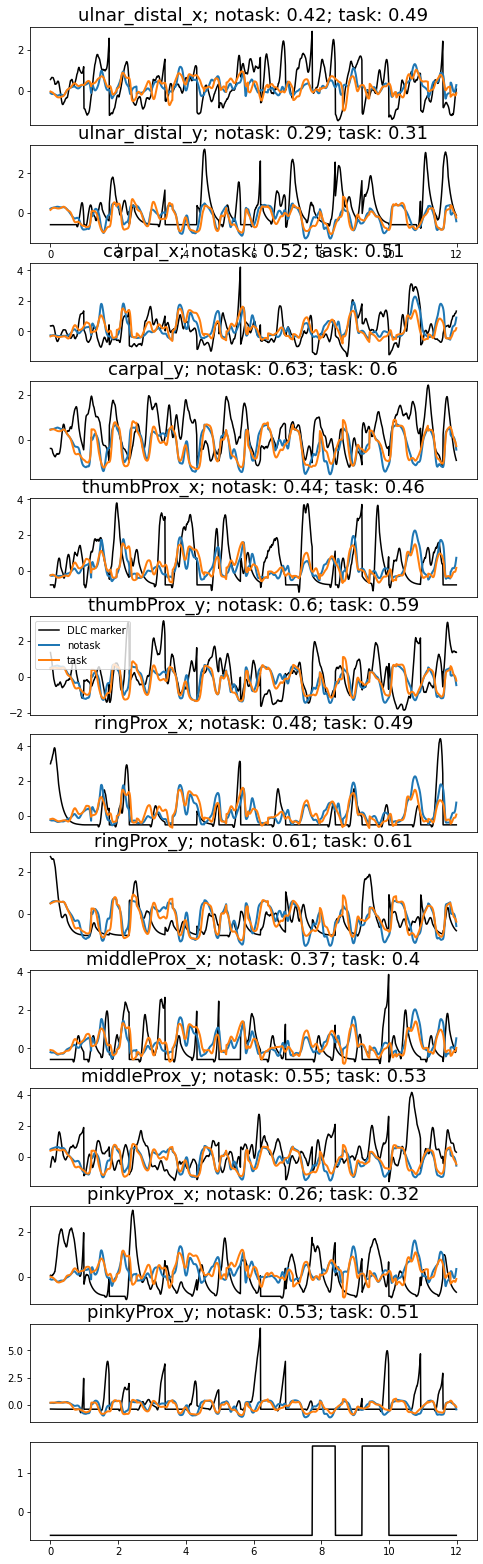

In [22]:
plt.figure(figsize=(8, 30))
tstart = 3000
bounds = np.arange(tstart, tstart + 1200)
x_vals = np.arange(len(bounds))/100

decoder_type = 'rnn'
# decoder_type = 'wiener'
cond1 = 'notask'
cond2 = 'task'

#marker_names = ['Carpal X', 'Carpal Y', 'Radius X', 'Radius Y', 'Ulnar X', 'Ulnar Y']
marker_names = np.concatenate([[f'{mrk}_x', f'{mrk}_y'] for mrk in marker_list])


for col_idx in range(len(marker_names)):
    plt.subplot(len(marker_names), 1, col_idx+1)
    plt.plot(x_vals, y_test_data[bounds, col_idx], color='k', label='DLC marker')
    plt.plot(x_vals, decode_results[decoder_type][cond1]['test_pred'][bounds, col_idx], color='C0', linewidth=2, label=cond1)
    plt.plot(x_vals, decode_results[decoder_type][cond2]['test_pred'][bounds, col_idx], color='C1', linewidth=2, label=cond2)


    layout_corr = np.round(decode_results[decoder_type][cond1]['test_corr'][col_idx], 2)
    nolayout_corr = np.round(decode_results[decoder_type][cond2]['test_corr'][col_idx], 2)
    plt.title(f"{marker_names[col_idx]}; {cond1}: {layout_corr}; {cond2}: {nolayout_corr}", fontsize=18)
    
    if col_idx == 1:
        plt.xlabel('Time (s)', fontsize=16)
    else:
        plt.xticks([])

    if col_idx == 5:
        plt.legend()
    
    plt.ylim(plt.ylim())
    plt.xlim(plt.xlim())
    
    #plt.vlines(x=[3, 6, 9, 12],ymin=-10000, ymax=100000, color='k', linewidth=10, linestyle='-', alpha=0.3)
plt.tight_layout()
# plt.savefig(f'movement_decoding_trajectory_{num_neurons}_neurons_layout.png')

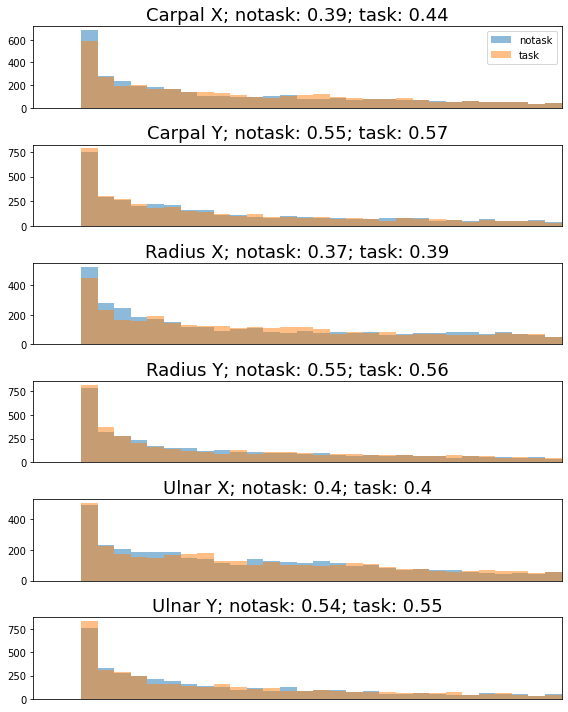

In [142]:
plt.figure(figsize=(8, 10))
tstart = 300

decoder_type = 'rnn'
# decoder_type = 'wiener'

bins = np.linspace(0,1,30)
for col_idx in range(len(marker_names)):
    plt.subplot(6, 1, col_idx+1)
    cond1_mse = np.square(decode_results[decoder_type][cond1]['test_pred'][:, col_idx] - y_test_data[:, col_idx])
    cond2_mse = np.square(decode_results[decoder_type][cond2]['test_pred'][:, col_idx] - y_test_data[:, col_idx])

    plt.hist(cond1_mse, color='C0', linewidth=2, label=cond1, bins=bins, alpha=0.5)
    plt.hist(cond2_mse, color='C1', linewidth=2, label=cond2, bins=bins, alpha=0.5)

    layout_corr = np.round(decode_results[decoder_type][cond1]['test_corr'][col_idx], 2)
    nolayout_corr = np.round(decode_results[decoder_type][cond2]['test_corr'][col_idx], 2)
    plt.title(f"{marker_names[col_idx]}; {cond1}: {layout_corr}; {cond2}: {nolayout_corr}", fontsize=18)
    
    if col_idx == 6:
        plt.xlabel('MSE', fontsize=16)
    else:
        plt.xticks([])
    
    if col_idx == 0:
        plt.legend()
    
    #plt.ylim(plt.ylim(0, 4000))
    plt.xlim(plt.xlim(-0.1, 1))
    
plt.tight_layout()
# plt.savefig(f'movement_decoding_mse_{num_neurons}_neurons_layout.png')

Text(0.5, 0.98, 'goCON -> endhold')

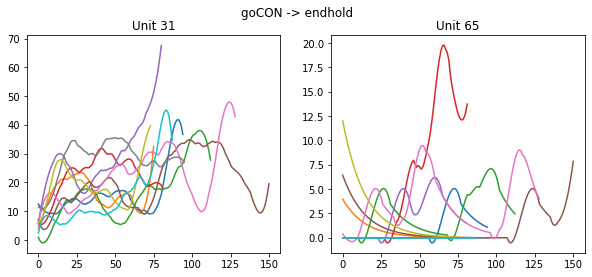

In [ ]:
# plt.figure(figsize=(10,4))
# for idx in range(10):
#     plt.subplot(1,2,1)
#     plt.plot(neural_df[neural_df['unit'] == str(random_units[0])]['rates'].values[idx])
#     plt.title('Unit 31')

#     plt.subplot(1,2,2)
#     plt.plot(neural_df[neural_df['unit'] == str(random_units[1])]['rates'].values[idx])
#     plt.title('Unit 65')

# plt.suptitle('goCON -> endhold')

(-0.05, 0.9)

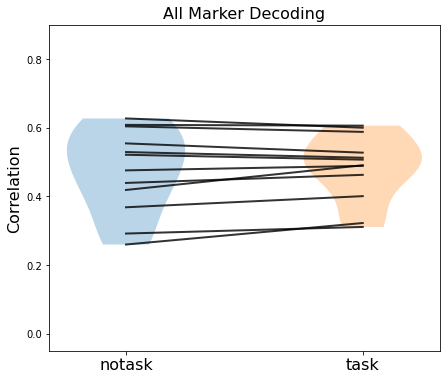

In [23]:
nolayout_test_corr = decode_results[decoder_type][cond1]['test_corr']
all_test_corr = decode_results[decoder_type][cond2]['test_corr']

plt.figure(figsize=(7,6))
plot_data = np.stack([nolayout_test_corr, all_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=[cond1, cond2], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(nolayout_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.title('All Marker Decoding', fontsize=16)
plt.ylim([-0.05,0.9])
# plt.savefig(f'movement_decoding_violin_{num_neurons}_neurons_layout.png')

In [ ]:
# plt.figure(figsize=(14,6))
# plt.subplot(1,2,1)
# plot_data = np.stack([proxjoint_test_corr, all_test_corr, finger_test_corr])
# _ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
# plt.xticks([0, 1, 2], labels=['ProxJoint', 'Combined', 'Finger'], fontsize=16)
# plt.ylabel('Correlation', fontsize=16)
# plt.violinplot(proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
# plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
# plt.violinplot(finger_test_corr, positions=[2], showmeans=False,showextrema=False)
# plt.title('ProxJoint/Finger vs. Combined', fontsize=16)
# plt.ylim([-0.05,0.9])

# plt.subplot(1,2,2)
# plot_data = np.stack([finger_proxjoint_test_corr, all_test_corr, eyes_test_corr])
# _ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
# plt.xticks([0, 1, 2], labels=['Finger+ProxJoint', 'Combined', 'Eyes'], fontsize=16)
# plt.ylabel('Correlation', fontsize=16)
# plt.violinplot(finger_proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
# plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
# plt.violinplot(eyes_test_corr, positions=[2], showmeans=False,showextrema=False)
# plt.title('Finger+ProxJoint/Eyes vs. Combined', fontsize=16)
# plt.ylim([-0.05,0.9])

# plt.savefig('single_unit_pred_final.svg')

In [ ]:
# compare_data_list = [all_test_pred, eyes_test_pred, finger_test_pred, proxjoint_test_pred]
# compare_data_names = ['Combined', 'Eyes', 'Fingers', 'Forelimb']

# data_arrays, generators = make_generators(kinematic_df, neural_df, neural_offset=20)
    
# # Unpack tuple into variables
# training_set, validation_set, testing_set = data_arrays
# training_generator, training_eval_generator, validation_generator, testing_generator = generators

# X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
# y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

# X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
# y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

# #Testing Data
# plt.figure(figsize=(14,8))
# bounds = np.arange(0,1500)
# x_vals = np.arange(len(bounds))/100
# unit_list = [4, 8, 16]

# for row_idx, unit_idx in enumerate(unit_list):
#     for plot_idx, (compare_data, name) in enumerate(zip(compare_data_list, compare_data_names)):
#         plt.subplot(3,4, plot_idx+1 + (4*row_idx))
#         plt.plot(x_vals, y_test_data[bounds,unit_idx], color='k')
#         plt.ylim(plt.ylim())
#         plt.plot(x_vals, compare_data[bounds,unit_idx], color=f'C{plot_idx + 1}')
#         plt.title(f'{name}: Unit {unit_idx}')
#         #plt.ylim([-3, 3.7])
        
#         if plot_idx == 0:
#             plt.ylabel('Firing Rate (a.u.)')
            
#         if row_idx == 2:
#             plt.xlabel('Time (s)')
#         else:
#             plt.xticks([])

#     plt.tight_layout()